## Lift a custom parcel

In [ ]:
%matplotlib inline

from skewt import SkewT

# Default Parcel
S=SkewT.Sounding("OTX_09082016.txt")
parcel=S.get_parcel(method='ml')
print parcel
print S.get_cape(*parcel)
S.plot_skewt()

# Custom Parcel
parcel=(800.0, 18.0, 3, 'ml')
S.make_skewt_axes(); S.add_profile();
S.lift_parcel(*parcel)
S.plot_skewt()

## Lift a parcel from a set altitude

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
from skewt import SkewT

df_snd = pd.read_csv('RAP_KEPH_130601_21z_F00.csv')

# Retrieve surface temperature
base_tmp = df_snd.loc[0]['TMP']
base_hgt = df_snd.loc[0]['HGT']

# Add the DALR

df_snd['DALR'] = base_tmp - ((df_snd.HGT-base_hgt)/1000)*9.8

# Virtual Temperature
df_snd['VIRTT'] = (df_snd.TMP+273.15)/(1 - 0.379*(6.11*np.power(((7.5*df_snd.DPT)/(237.7+df_snd.DPT)),10))/df_snd.level)-273.15

# Thermal Index
df_snd['TI'] = df_snd.TMP - df_snd.DALR

hght = df_snd[['HGT']].as_matrix().flatten()
pres = df_snd[['level']].as_matrix().flatten()
temp = df_snd[['TMP']].as_matrix().flatten()
dwpt = df_snd[['DPT']].as_matrix().flatten()
sknt = df_snd[['WSPD']].as_matrix().flatten()
drct = df_snd[['WDIR']].as_matrix().flatten()

mydata=dict(zip(('hght','pres','temp','dwpt','sknt', 'drct'),(hght, pres, temp, dwpt, sknt, drct)))
S=SkewT.Sounding(soundingdata=mydata)
S.plot_skewt(color='r')


363.722 547 588.141
          HGT         TI
0     588.141   0.000000
1     816.830  -0.158848
2    1049.990  -0.276880
3    1287.770  -0.376636
4    1530.300  -0.470842
5    1778.000  -0.474382
6    2031.060  -0.431394
7    2289.960  -0.271174
8    2555.150   0.029688
9    2827.120   0.774994
10   3106.700   1.607878
11   3394.270   2.545064
12   3690.640   3.576490
13   3996.410   4.758036
14   4312.000   5.827818
15   4638.870   7.209144
16   4977.290   8.548660
17   5329.370  10.104044
18   5695.150  11.591688
19   6077.280  13.193562
20   6475.880  14.701842
21   6892.870  16.047344
22   7330.360  17.098746
23   7789.760  18.144866
24   8273.250  19.035068
25   8783.680  19.851282
26   9324.770  20.587964
27   9901.450  21.984428
28  10523.100  25.192598
29  11204.900  31.351238
30  11968.900  40.099438
31  12839.800  49.506258
32  13846.300  58.991958
33  15031.900  69.164838
34  16467.600  80.284698
2289.96

---- Lifted Parcel Quantities ----
Parcel: INTERP
Ps  : 954.6hPa
TCs : 

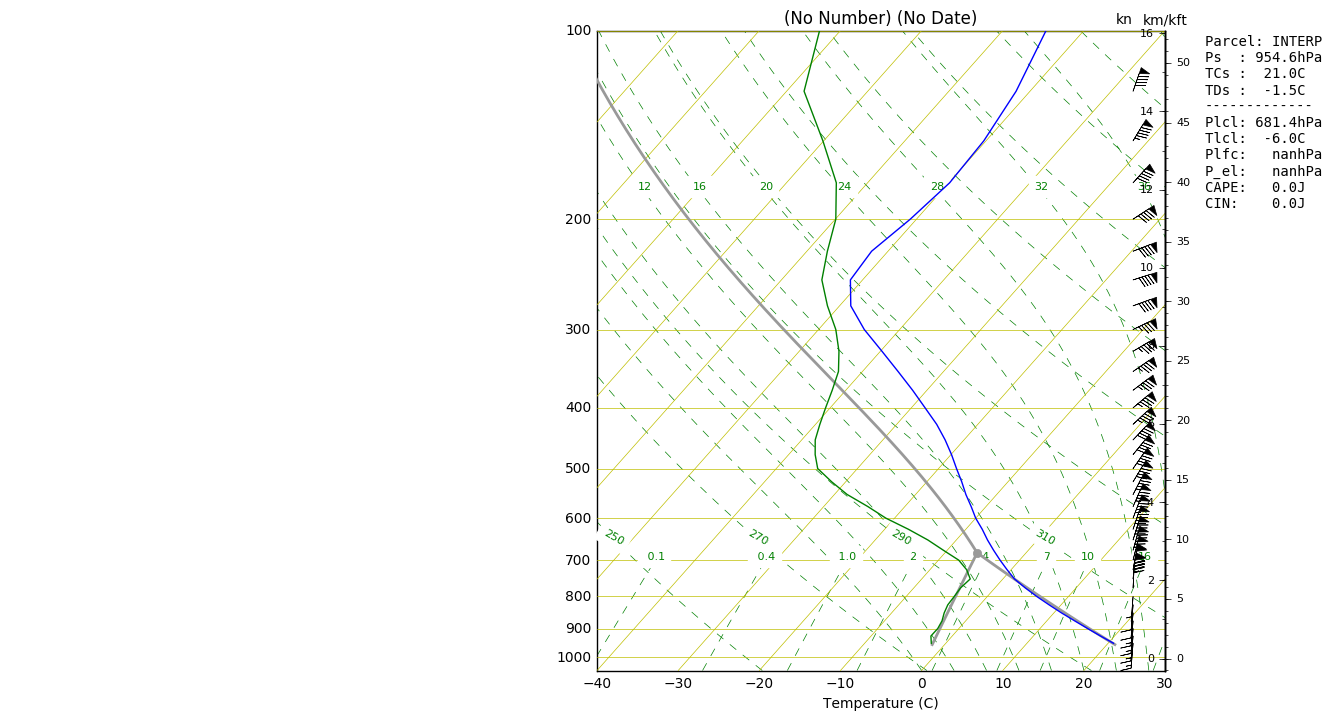

In [10]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import sys
import gdal
import math
from gdalconst import GA_ReadOnly
from skewt import SkewT

def open_raster():
    """
    This functions opens the raster file for processing
    """
    try:
        raster = gdal.Open('SRTM/srtm_13_03.tif', GA_ReadOnly)
    except RuntimeError, exception:
        print 'Unable to open '+'srtm_12_03.tif'
        print exception
        sys.exit(1)
    return raster

def retrieve_band(longitude, latitude):
    """
    This function will take in the given coordinates and return the
    elevation(band) NOTE: this only takes in Mercator value does not
    work with WGS84
    x - coordinates for the x axis or the longitude that users defined
    y - coordinates for the y axis or the latitude that user defined
    """
    if -180.0 > longitude > 180.0 or -90 > latitude > 90:
        return NULL_VALUE
    else:
        raster = open_raster()
        transform = raster.GetGeoTransform()
        x_offset = int((longitude - transform[0]) / transform[1])
        y_offset = int((latitude - transform[3]) / transform[5])
        band = raster.GetRasterBand(1)
        data = band.ReadAsArray(x_offset, y_offset, 1, 1)
        return data[0][0]

# Dewpoint calculation adapted from ...
def dew_point(df_snd):
    
    df_snd['DPT_B'] = df_snd.TMP_C.apply(lambda x: 17.368 if x > 0 else 17.966)
    df_snd['DPT_C'] = df_snd.TMP_C.apply(lambda x: 238.88 if x > 0 else 247.15)

    pa = df_snd.RH / 100. * np.exp(df_snd.DPT_B * df_snd.TMP_C / (df_snd.DPT_C + df_snd.TMP_C))
    df_snd['DEWP_C'] = df_snd.DPT_C * np.log(pa) / (df_snd.DPT_B - np.log(pa))

def calc_hgt(df_snd, p):
    upper_hgt, upper_level = df_snd.loc[df_snd['level'] <= p].iloc[0][['HGT','level']]
    lower_hgt, lower_level = df_snd.loc[df_snd['level'] >= p].iloc[-1][['HGT', 'level']]
    print upper_level, p, lower_level
    lvls = range(int(upper_level),int(lower_level)+1)
    hghts = np.empty(len(lvls))
    hghts[:] = np.NAN
    hghts[0] = upper_hgt
    hghts[-1] = lower_hgt
    df_hght = pd.DataFrame({'level': lvls, 'HGT': hghts}).interpolate()
    hgt, level = df_hght.loc[df_hght['level'] == int(p)].iloc[0][['HGT','level']]
    return hgt

def get_parcel_at_hgt(terrain, df_snd):
    upper_hgt, upper_level, upper_tmp_c, upper_dewp_c = df_snd.loc[df_snd['HGT'] >= terrain].iloc[0][['HGT','level','TMP_C','DEWP_C']]
    lower_hgt, lower_level, lower_tmp_c, lower_dewp_c = df_snd.loc[df_snd['HGT'] <= terrain].iloc[-1][['HGT', 'level','TMP_C','DEWP_C']]
    print lower_hgt, terrain , upper_hgt
    hgts = range(int(lower_hgt),int(upper_hgt)+1)
    interp = np.empty(len(hgts))
    interp[:] = np.NAN
    levels = list(interp)
    levels[0] = lower_level
    levels[-1] = upper_level
    temps = list(interp)
    temps[0] = lower_tmp_c
    temps[-1] = upper_tmp_c
    dewpts = list(interp)
    dewpts[0] = lower_dewp_c
    dewpts[-1] = upper_dewp_c
    df_interp = pd.DataFrame({'HGT': hgts, 'level': levels, 'TMP_C': temps, 'DEWP_C': dewpts}).interpolate()
    hgt, level, tmp_c, dewp_c = df_interp.loc[df_interp['HGT'] == int(terrain)].iloc[0][['HGT','level','TMP_C','DEWP_C']]
    return (level, tmp_c, dewp_c, 'interp')

def strip_to_terrain(df_snd, parcel):
    level, tmp_c, dewp_c, pcl = parcel
    # Reduce the sounding to terrain height.
    return df_snd.loc[df_snd['level'] <= level].reset_index(drop=True)


df = pd.read_csv('68de910c-ff55-4be7-b163-0d46e8a94c97.csv')

# Geopotential Height
df_hgt = df.loc[df['paramId'] == 156][0:37]
df_hgt = df_hgt.rename(columns={'value':'HGT'}).drop('paramId', 1)

# Temperature
df_tmp = df.loc[df['paramId'] == 130][0:37]
df_tmp = df_tmp.rename(columns={'value':'TMP_K'}).drop('paramId', 1)
 
# Relative Humidity
df_rh = df.loc[df['paramId'] == 157][0:37]
df_rh = df_rh.rename(columns={'value':'RH'}).drop('paramId', 1)

# U component of wind
df_uw = df.loc[df['paramId'] == 131][0:37]
df_uw = df_uw.rename(columns={'value':'W_U'}).drop('paramId', 1)

# V component of wind
df_vw = df.loc[df['paramId'] == 132][0:37]
df_vw = df_vw.rename(columns={'value':'W_V'}).drop('paramId', 1)

# Ground Temperature
df_gtmp = df.loc[df['paramId'] == 167]

dfs = [df_hgt, df_tmp, df_rh, df_uw, df_vw]

df_snd = reduce(lambda left,right: pd.merge(left,right,on='level'), dfs)

# Wind Speed
df_snd['W_SPD_MS'] = (df_snd.W_U**2 + df_snd.W_V**2)**(0.5)
df_snd['W_SPD_KTS'] = df_snd.W_SPD_MS * 1.94384

# Wind Direction
df_snd['W_DIR'] = np.arctan2(df_snd.W_U, df_snd.W_V) * (180./np.pi)

# Temperature in Celcius
df_snd['TMP_C'] = df_snd.TMP_K - 273.15

# Dewpoint Temperature
dew_point(df_snd)

# Get the lift parcel for the terrain altitude
terrain = retrieve_band(-119.56293333337,47.3514166666813)
parcel = get_parcel_at_hgt(terrain, df_snd)
df_snd = strip_to_terrain(df_snd,parcel)

# Retrieve surface temperature
base_tmp = df_snd.loc[0]['TMP_C']
base_hgt = df_snd.loc[0]['HGT']

# Add the DALR

df_snd['DALR'] = base_tmp - ((df_snd.HGT-base_hgt)/1000)*9.8

# Virtual Temperature
df_snd['VIRTT'] = (df_snd.TMP_K)/(1 - 0.379*(6.11*np.power(((7.5*df_snd.DEWP_C)/(237.7+df_snd.DEWP_C)),10))/df_snd.level)-273.15

# Thermal Index
df_snd['TI'] = df_snd.TMP_C - df_snd.DALR
print df_snd[['HGT','TI']]

# Top of lift
top_lift = df_snd.loc[df_snd['TI'] <= 0].iloc[-1]['HGT']
print top_lift

hght = df_snd[['HGT']].as_matrix().flatten()
pres = df_snd[['level']].as_matrix().flatten()
temp = df_snd[['TMP_C']].as_matrix().flatten()
dwpt = df_snd[['DEWP_C']].as_matrix().flatten()
sknt = df_snd[['W_DIR']].as_matrix().flatten()
drct = df_snd[['W_SPD_KTS']].as_matrix().flatten()

mydata=dict(zip(('hght','pres','temp','dwpt','sknt', 'drct'),(hght, pres, temp, dwpt, sknt, drct)))
S=SkewT.Sounding(soundingdata=mydata)
S.make_skewt_axes(); S.add_profile();
S.lift_parcel(*parcel)
Plcl, Plfc, P_el, CAPE, CIN = S.get_cape(*parcel)

Hlcl = calc_hgt(df_snd, Plcl)
if (math.isnan(Plfc)):
    Hlfc = Plfc
else:
    Hlfc = calc_hgt(df_snd, Plfc)

if (math.isnan(P_el)):
    H_el = P_el
else:
    H_el = calc_hgt(df_snd, P_el)

print Plcl, Hlcl, Plfc, Hlfc, P_el, H_el, CAPE, CIN 


In [ ]:
lvls = range(700,726)
hghts = np.empty(len(lvls))
hghts[:] = np.NAN
hghts[0] = 2827.12
hghts[-1] = 3106.7
df_hght = pd.DataFrame({'level': lvls, 'HGT': hghts}).interpolate()
print df_hght
df_lookup = df_hght.loc[df_hght['level'] == 710]
print df_lookup
hgt, level = df_lookup.iloc[0][['HGT','level']]
print level, hgt

In [ ]:
import os
import sys
import gdal
import math
from gdalconst import GA_ReadOnly

def open_raster():
    """
    This functions opens the raster file for processing
    """
    try:
        raster = gdal.Open('SRTM/srtm_12_03.tif', GA_ReadOnly)
    except RuntimeError, exception:
        print 'Unable to open '+'srtm_12_03.tif'
        print exception
        sys.exit(1)
    return raster

def retrieve_band(longitude, latitude):
    """
    This function will take in the given coordinates and return the
    elevation(band) NOTE: this only takes in Mercator value does not
    work with WGS84
    x - coordinates for the x axis or the longitude that users defined
    y - coordinates for the y axis or the latitude that user defined
    """
    if -180.0 > longitude > 180.0 or -90 > latitude > 90:
        return NULL_VALUE
    else:
        raster = open_raster()
        transform = raster.GetGeoTransform()
        x_offset = int((longitude - transform[0]) / transform[1])
        y_offset = int((latitude - transform[3]) / transform[5])
        band = raster.GetRasterBand(1)
        data = band.ReadAsArray(x_offset, y_offset, 1, 1)
        return data[0]
    
print retrieve_band(-121.7968, 48.0579)